# Analyze Xenium data 

In [1]:
import spatialdata as sd
from spatialdata_io import xenium

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


A reader for Xenium data is available in `spatialdata-io`. We use it to parse and convert to Zarr a [Xenium dataset of Human Lung Cancer](https://www.10xgenomics.com/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard).

After downloading and extracting the dataset into a directory named Xenium, we specify the path to the dataset and where we want to store our Zarr files.

In [2]:
# xenium_path = "./Xenium"
# zarr_path = "./Xenium.zarr"

load the data into a spatialdata object using the xenium reader.

In [3]:
# sdata = xenium(xenium_path)

Convert to Zarr.

In [4]:
# sdata.write(zarr_path)

From now on we only read directly from the zarr store.

In [5]:
# zarr_path = '/Volumes/Share1TB/datasets/lv_0046706_053.zarr'

# zarr_path = "/Users/chrism/datasets/lv_0046706_053.zarr"
# zarr_path = "/Users/chrism/datasets/lv_0046859_033.zarr"
# zarr_path = "/Users/chrism/datasets/lv_0046859_039.zarr"
# zarr_path = "/Users/chrism/datasets/lv_0046859_736_control.zarr"
# zarr_path = "/Users/chrism/datasets/lv_0046706_117.zarr"
zarr_path = "/Users/chrism/datasets/lv_0046706_007.zarr"

sdata = sd.read_zarr(zarr_path)
sdata

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/chrism/git/spatialdata-notebooks/.venv/

SpatialData object, with associated Zarr store: /Users/chrism/datasets/lv_0046706_007.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 10778, 21529), (4, 5389, 10764), (4, 2694, 5382), (4, 1347, 2691), (4, 674, 1346)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (10778, 21529), (5389, 10764), (2694, 5382), (1347, 2691), (674, 1346)
│     └── 'nucleus_labels': DataTree[yx] (10778, 21529), (5389, 10764), (2694, 5382), (1347, 2691), (674, 1346)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (14328, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (14325, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (14122, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (14325, 310)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundar

For the analysis we use the `anndata.AnnData` object, which contains the count matrix, cell and gene annotations. It is stored in the `spatialdata.tables` layer. 

In [6]:
adata = sdata.tables["table"]
# gene_name = ["VWF", "SELE", "CLDN5", "KDR", "CDH5", "ENG"]
# adata = adata[:, gene_name].copy()
adata

AnnData object with n_obs × n_vars = 14325 × 310
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

Squidpy looks for cell coordinates in `.obsm["spatial"]`. By using the Xenium reader from `spatialdata-io` this is already automatically set. For more complex data this needs to be set manually, more details can be found in this [spatialdata tutorial on squidpy integration](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/squidpy_integration.html).

## Calculate quality control metrics 

Calculate the quality control metrics on the `anndata.AnnData` using `scanpy.pp.calculate_qc_metrics`.

In [7]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

The percentage of control probes and control codewords can be calculated from `adata.obs`

In [8]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.01145058410032158
Negative decoding count % : 0.003796772622738208


Next we plot the distribution of total transcripts per cell, unique transcripts per cell, area of segmented cells and the ratio of nuclei area to their cells

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

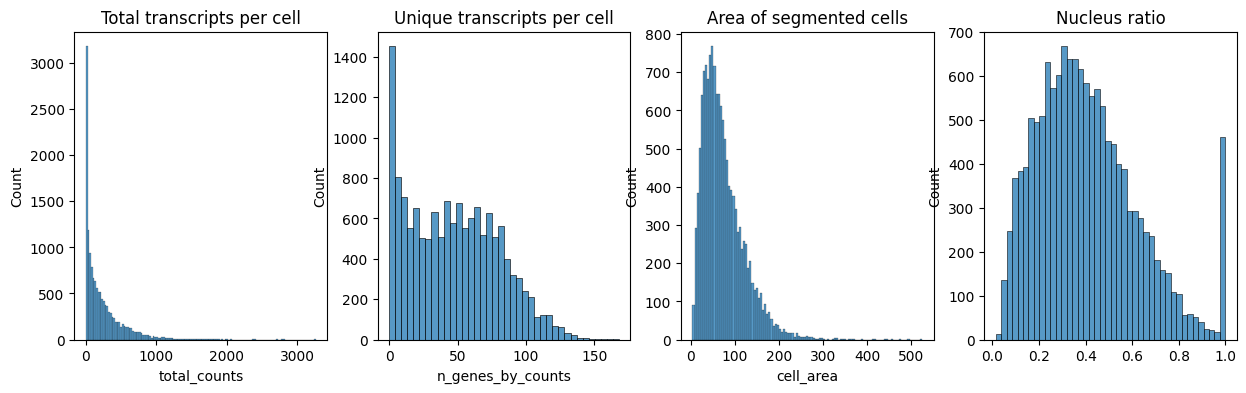

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

Filter the cells based on the minimum number of counts required using `scanpy.pp.filter_cells`. Filter the genes based on the minimum number of cells required with `scanpy.pp.filter_genes`. The parameters for the both were specified based on the plots above. They were set to filter out the cells and genes with minimum counts and minimum cells respectively.

Other filter criteria might be cell area, DAPI signal or a minimum of unique transcripts.

In [10]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

Normalize counts per cell using `scanpy.pp.normalize_total`.

Logarithmize, do principal component analysis, compute a neighborhood graph of the observations using `scanpy.pp.log1p`, `scanpy.pp.pca` and `scanpy.pp.neighbors` respectively.

Use `scanpy.tl.umap` to embed the neighborhood graph of the data and cluster the cells into subgroups employing `scanpy.tl.leiden`.

In [11]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/xz/289tk8xn6zl90c3p1t1jpwxw0000gn/T/ipykernel_73492/4193936636.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


## Visualize annotation on UMAP and spatial coordinates 

Subplot with scatter plot in UMAP (Uniform Manifold Approximation and Projection) basis. The embedded points were colored, respectively, according to the total counts, number of genes by counts, and leiden clusters in each of the subplots. This gives us some idea of what the data looks like.

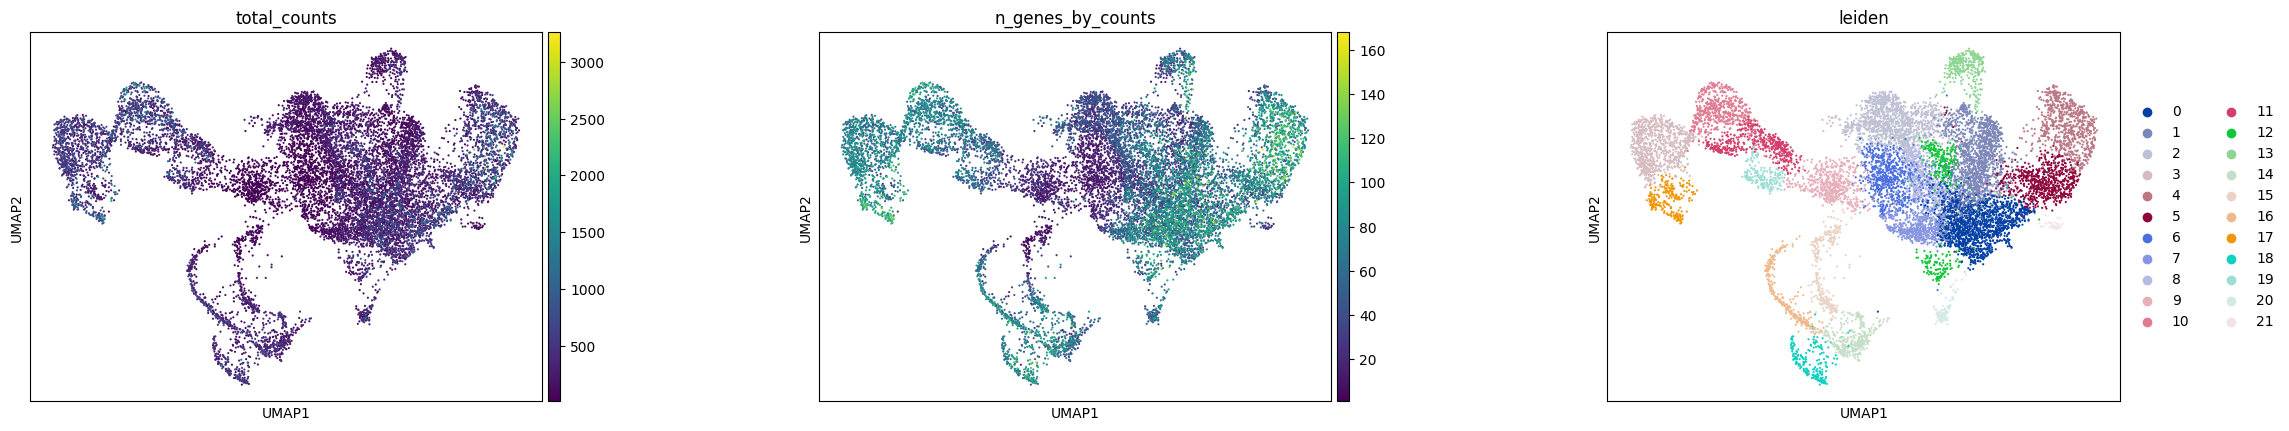

In [12]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


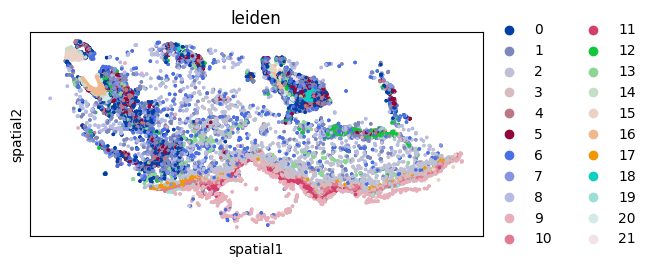

In [13]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## Computation of spatial statistics 

This example shows how to compute centrality scores, given a spatial graph and cell type annotation.

The scores calculated are closeness centrality, degree centrality and clustering coefficient with the following properties:

- closeness centrality - measure of how close the group is to other nodes.
- clustering coefficient - measure of the degree to which nodes cluster together.
- degree centrality - fraction of non-group members connected to group members.

All scores are descriptive statistics of the spatial graph.

This dataset contains Leiden cluster groups’ annotations in `adata.obs`, which are used for calculation of centrality scores.

### Building a spatial neighborhood graph

First, we need to compute a connectivity matrix from spatial coordinates to calculate the centrality scores. We can use `squidpy.gr.spatial_neighbors` for this purpose. We use the `coord_type="generic"` based on the data and the neighbors are classified with Delaunay triangulation by specifying `delaunay=True`.

In [14]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

### Compute centrality scores 

Centrality scores are calculated with `squidpy.gr.centrality_scores`, with the Leiden groups as clusters.

In [15]:
sq.gr.centrality_scores(adata, cluster_key="leiden")

The results were visualized by plotting the average centrality, closeness centrality, and degree centrality using `squidpy.pl.centrality_scores`.

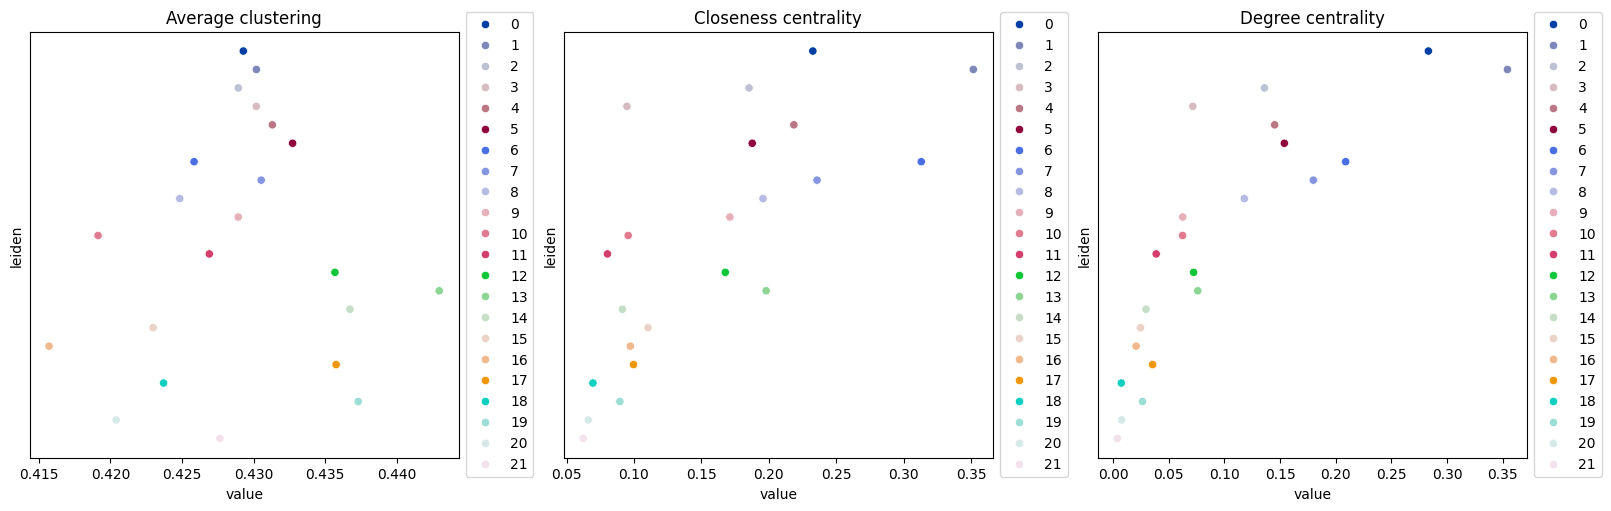

In [16]:
sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(16, 5))

### Compute co-occurrence probability 

This example shows how to compute the co-occurrence probability.

The co-occurrence score is defined as:

$\frac{p(exp|cond)}{p(exp)}$

where $p(exp|cond)$ is the conditional probability of observing a cluster $exp$ conditioned on the presence of a cluster $cond$, whereas $p(exp)$ is the probability of observing $exp$ in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

We can compute the co-occurrence score with `squidpy.gr.co_occurrence`. Results of co-occurrence probability ratio can be visualized with `squidpy.pl.co_occurrence`. The ‘3’ in the $\frac{p(exp|cond)}{p(exp)}$ represents a Leiden clustered group.

We can further visualize tissue organization in spatial coordinates with `squidpy.pl.spatial_scatter`, with an overlay of the expressed genes which were colored in consonance with the Leiden clusters.

First we create a new table, which is a subset of the original Anndata object, and store it in tables.

In [17]:
sdata.tables["subsample"] = sc.pp.subsample(adata, fraction=0.5, copy=True)

You can also work with `sdata.tables["subsample"]` directly, but to keep verbosity low, we just use the `anndata.Anndata` object as before.

In [18]:
adata_subsample = sdata.tables["subsample"]

  0%|                                                                                                                                                                                           | 0/1 [00:00<?, ?/s]/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


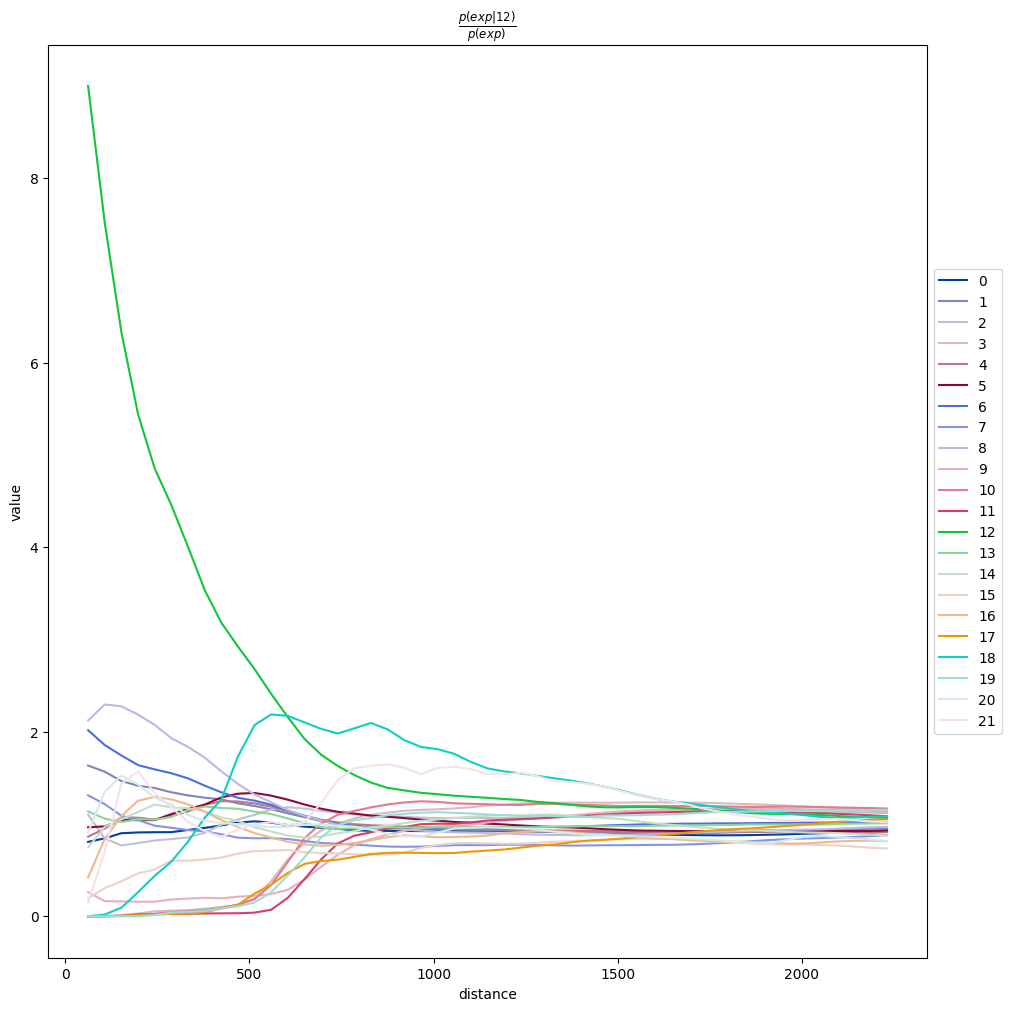

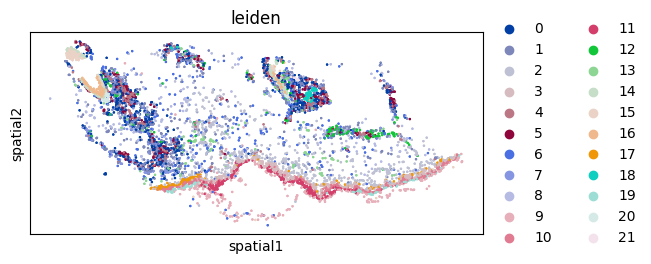

In [19]:
sq.gr.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
)
sq.pl.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
    clusters="12",
    figsize=(10, 10),
)
sq.pl.spatial_scatter(
    adata_subsample,
    color="leiden",
    shape=None,
    size=2,
)

### Neighbors enrichment analysis 


This example shows how to run the neighbors enrichment analysis routine.

It calculates an enrichment score based on proximity on the connectivity graph of cell clusters. The number of observed events is compared against  permutations and a z-score is computed.

This dataset contains cell type annotations in `adata.obs` which are used for calculation of the neighborhood enrichment. We calculate the neighborhood enrichment score with `squidpy.gr.nhood_enrichment`.

In [20]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

  0%|                                                                                                                                                                                        | 0/1000 [00:00<?, ?/s]/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

And visualize the results with `squidpy.pl.nhood_enrichment`.

/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


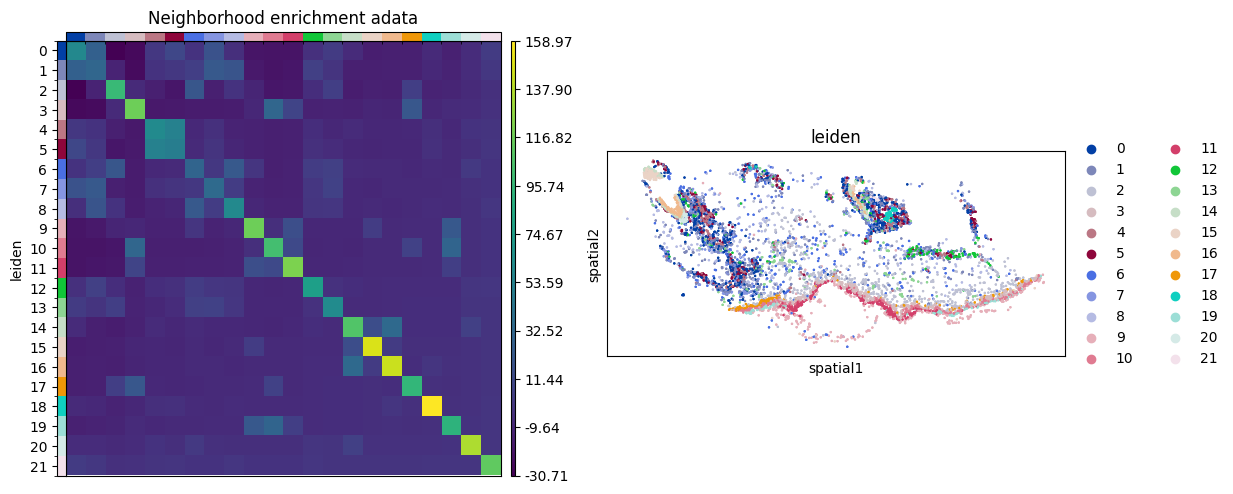

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata_subsample, color="leiden", shape=None, size=2, ax=ax[1])

### Compute Moran's I score 


This example shows how to compute the Moran’s I global spatial auto-correlation statistics.

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

We can compute the Moran’s I score with `squidpy.gr.spatial_autocorr` and mode = 'moran'. We first need to compute a spatial graph with `squidpy.gr.spatial_neighbors`. We will also subset the number of genes to evaluate.

In [22]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata.uns["moranI"].head(10)

  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?/s]/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
KRT5      0.796234        0.0  0.000028         0.0  0.009901  0.000084   
TACSTD2   0.793856        0.0  0.000028         0.0  0.009901  0.000079   
SLPI      0.779348        0.0  0.000028         0.0  0.009901  0.000063   
S100A14   0.756188        0.0  0.000028         0.0  0.009901  0.000078   
CLDN1     0.738969        0.0  0.000028         0.0  0.009901  0.000057   
KRT15     0.734845        0.0  0.000028         0.0  0.009901  0.000062   
SERPINB5  0.730115        0.0  0.000028         0.0  0.009901  0.000074   
COCH      0.707371        0.0  0.000028         0.0  0.009901  0.000067   
FGFBP1    0.683362        0.0  0.000028         0.0  0.009901  0.000072   
TP63      0.678368        0.0  0.000028         0.0  0.009901  0.000057   

          pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
KRT5                   0.0                0.0         0.010372  
TACSTD2                0.0                0.0         0.010372  
SLPI                   0.0                0.0         0.010372  
S100A14                0.0                0.0         0.010372  
CLDN1                  0.0                0.0         0.010372  
KRT15                  0.0                0.0         0.010372  
SERPINB5               0.0                0.0         0.010372  
COCH                   0.0                0.0         0.010372  
FGFBP1                 0.0                0.0         0.010372  
TP63                   0.0                0.0         0.010372

We can visualize some of those genes with `squidpy.pl.spatial_scatter`. We could also pass `mode = 'geary'` to compute a closely related auto-correlation statistic, Geary’s C. See `squidpy.gr.spatial_autocorr` for more information.

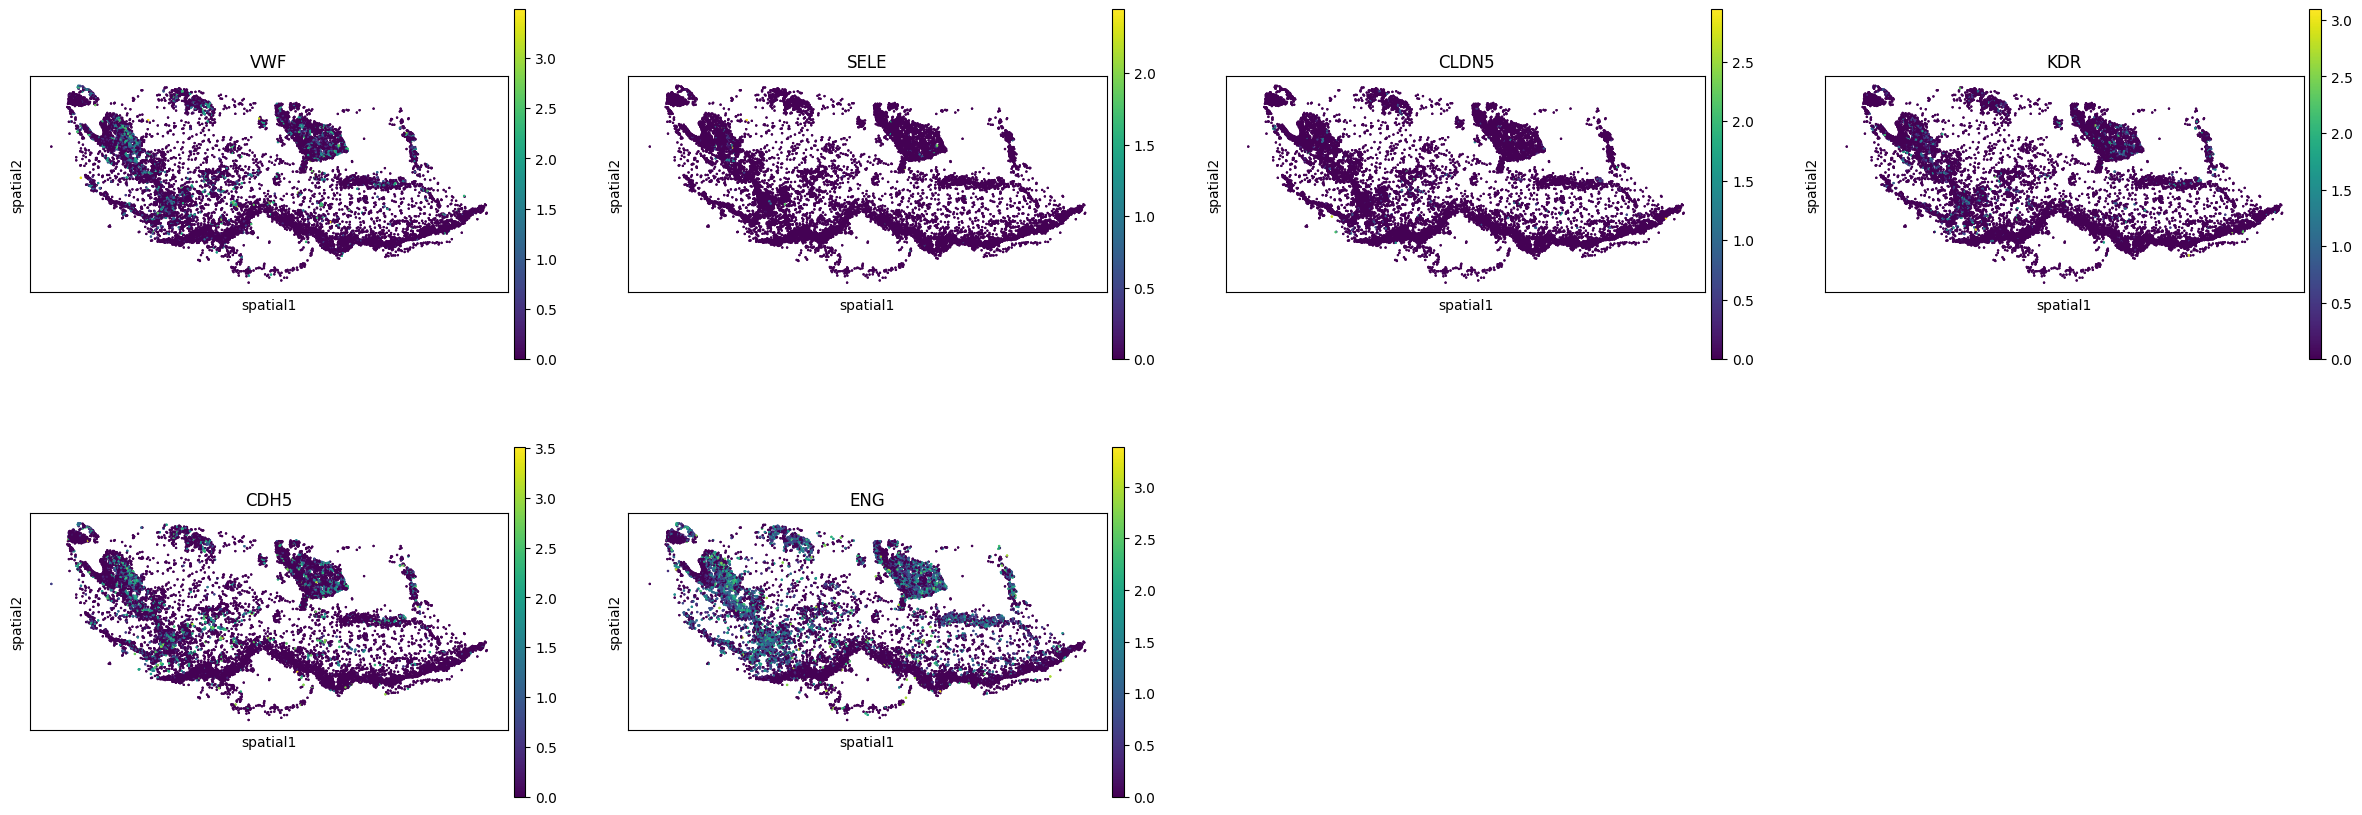

In [23]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "VWF",
        "SELE",
        "CLDN5",
        "KDR",
        "CDH5",
        "ENG"
    ],
    shape=None,
    size=2,
    img=False,
)

For plotting we can also use `spatialdata-plot`, a package for static plotting of `spatialdata`objects.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5871280276816608].


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5871280276816608].


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5871280276816608].


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5871280276816608].


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5871280276816608].


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5871280276816608].


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/chrism/git/spatialdata-notebooks/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


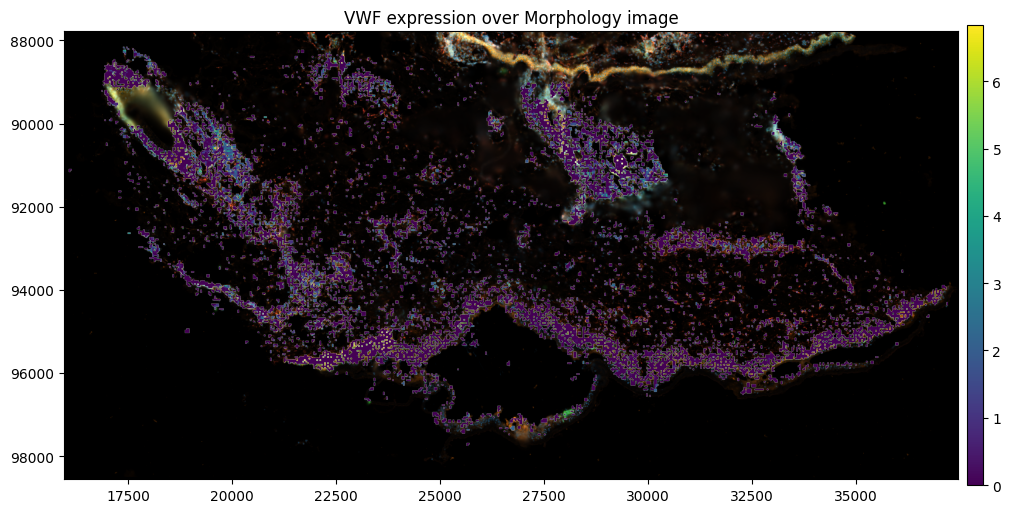

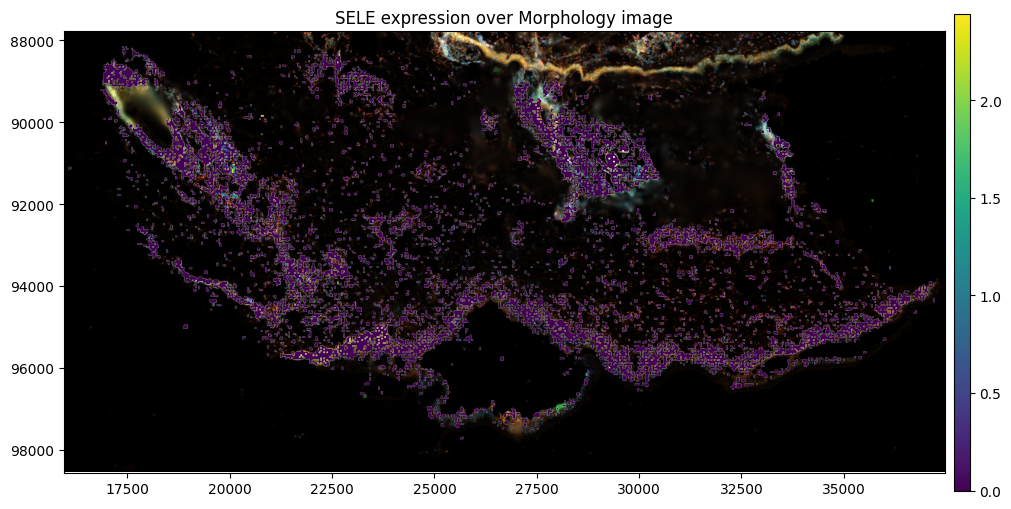

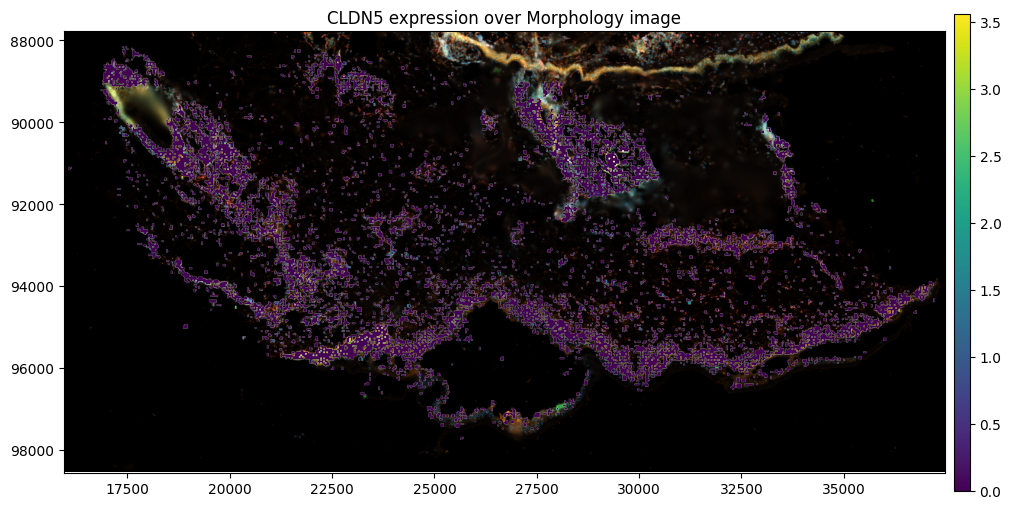

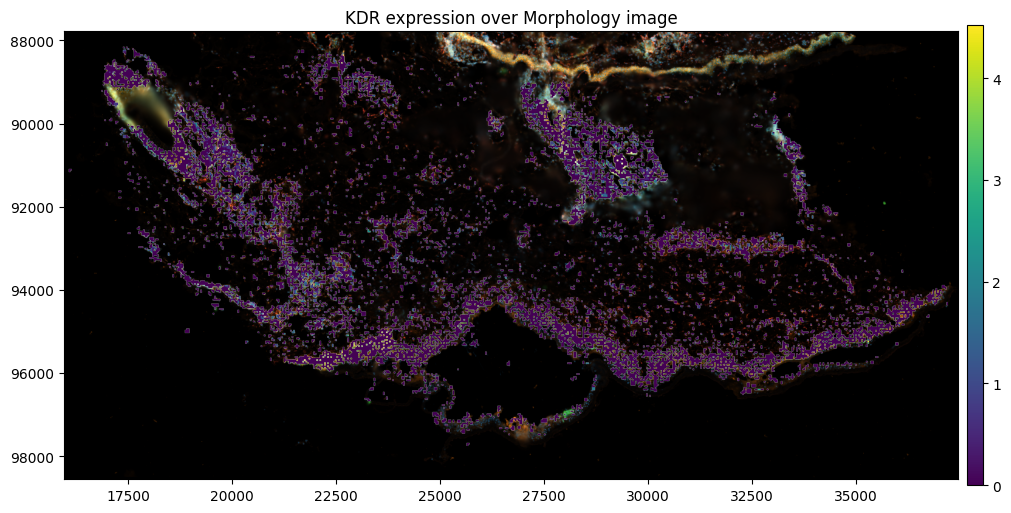

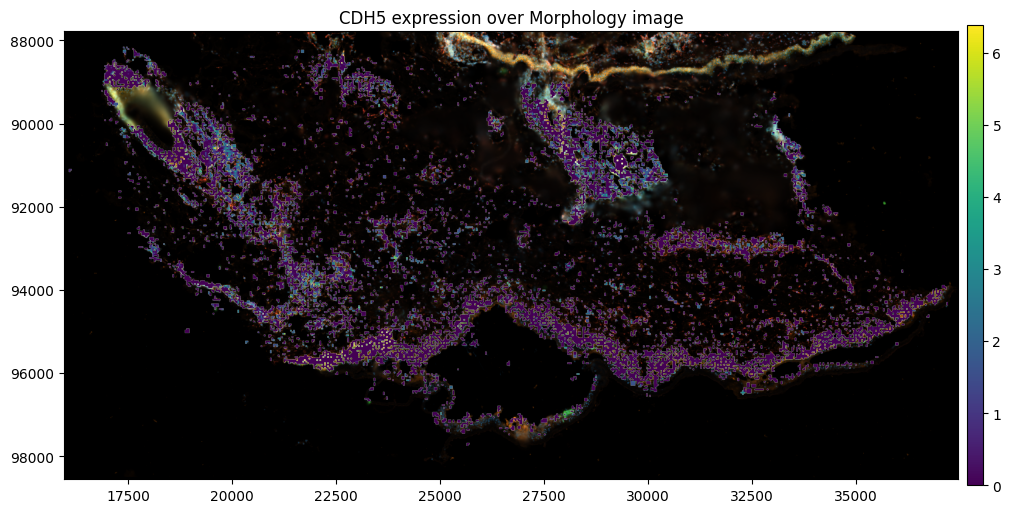

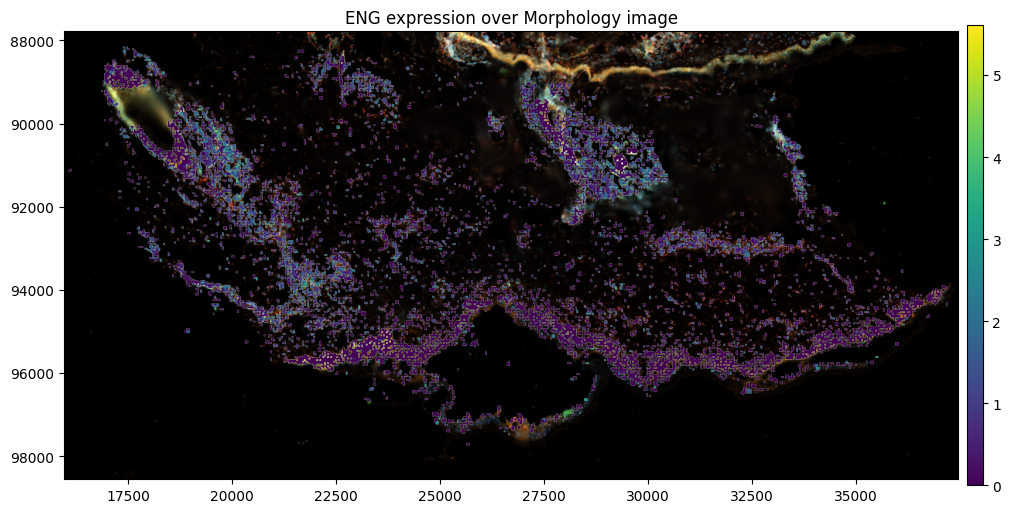

In [24]:
import spatialdata_plot

# gene_name = ["AREG", "MET"]
gene_name = ["VWF", "SELE", "CLDN5", "KDR", "CDH5", "ENG"]
for name in gene_name:
    sdata.pl.render_images("morphology_focus").pl.render_shapes(
        "cell_circles",
        color=name,
        table_name="table",
        use_raw=False,
    ).pl.show(
        title=f"{name} expression over Morphology image",
        coordinate_systems="global",
        figsize=(10, 5),
    )

## Interactive analysis and visualization with `napari-spatialdata`

Additionally, one can use `napari-spatialdata` to visualize Xenium data with an interactive GUI.

In [25]:
# from napari_spatialdata import Interactive

# Interactive(sdata)

Here we visualize AREG expression across all cells: